In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir("/content/drive/MyDrive/kp-gpt2-nlp")
print(os.getcwd())

/content/drive/MyDrive/kp-gpt2-nlp


In [ ]:
%pip install -q -r requirements_colab.txt
print("Dependencies installed successfully.")

Dependencies installed successfully.


In [ ]:
import torch
from torch import nn, dtype
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.utils.data import random_split, DataLoader, Dataset
from config import PretrainedConfig, GPT2Config
from transformers import GPT2Model as OpenAIGPT2Model
from transformers import GPT2Tokenizer
from transformers import AutoModelForCausalLM, AutoTokenizer
from utils import *
from einops import rearrange
from typing import Callable, Iterable, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from tqdm import tqdm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Task 1: Implement GPT-2
In this task, you will:
- Load the GPT-2 tokenizer.
- Implement the GPT-2 model.
- Implement the Adam optimizer.
- Conduct a toy pretraining of GPT-2 on the provided small dataset.

## Tokenizer

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
text = "Welcome, this is the beginning of default final project!"
input_ids = tokenizer(text)['input_ids']
print('input_ids:', input_ids)
for token in input_ids:
    print('token', tokenizer.decode(token))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

input_ids: [14618, 11, 428, 318, 262, 3726, 286, 4277, 2457, 1628, 0]
token Welcome
token ,
token  this
token  is
token  the
token  beginning
token  of
token  default
token  final
token  project
token !


## Model

In [ ]:
class CausalSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.num_attention_heads = config.num_attention_heads
    self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
    self.all_head_size = self.num_attention_heads * self.attention_head_size

    # Initialize the linear transformation layers for key, value, query.
    self.query = nn.Linear(config.hidden_size, self.all_head_size)
    self.key = nn.Linear(config.hidden_size, self.all_head_size)
    self.value = nn.Linear(config.hidden_size, self.all_head_size)
    # This dropout is applied to normalized attention scores following the original
    # implementation of transformer. Although it is a bit unusual, we empirically
    # observe that it yields better performance.
    self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

  def transform(self, x, linear_layer):
    # The corresponding linear_layer of k, v, q are used to project the hidden_state (x).
    proj = linear_layer(x)
    # Next, we need to produce multiple heads for the proj. This is done by spliting the
    # hidden state to self.num_attention_heads, each of size self.attention_head_size.
    proj = rearrange(proj, 'b t (h d) -> b t h d', h=self.num_attention_heads)
    # By proper transpose, we have proj of size [bs, num_attention_heads, seq_len, attention_head_size].
    proj = rearrange(proj, 'b t h d -> b h t d')
    return proj

  def attention(self, key, query, value, attention_mask):
    """
    TODO-1: Compute scaled dot-product attention for GPT-2.

    Implementation hints:
    1. Compute raw attention scores using QK^T, and scale them by sqrt(d_k).
    2. Apply a causal mask (lower-triangular) to prevent attending to future tokens.
    3. Optionally add the external attention_mask (e.g., padding positions).
    4. Normalize the scores with softmax to obtain attention probabilities.
    5. Apply dropout on the probabilities.
    6. Use them to weight the values (V) and obtain the context vectors.
    7. Finally, merge all attention heads back into a single hidden representation.
    """

    ### YOUR CODE HERE

    # Compute raw attention scores using QK^T, and scale them by sqrt(d_k).
    # q, k, v shapes: [B, H, T, d]
    raw_scores = torch.matmul(query, key.transpose(-2, -1))  # [B, H, T, T]
    d_k = query.size(-1)
    scaled_scores = raw_scores / (torch.sqrt(torch.tensor(d_k, dtype=torch.float32)))

    # Apply a causal mask over the token dimension (lower triangular over T x T).
    Tq = query.size(-2)
    Tk = key.size(-2)
    causal = torch.tril(torch.ones((Tq, Tk), device=query.device, dtype=torch.bool))  # [Tq, Tk]; 1 for keep, 0 for mask; create a lower triangular mask
    scaled_scores = scaled_scores.masked_fill(~causal, torch.finfo(scaled_scores.dtype).min)  # Fill masked positions with -inf

    # Optionally add the external attention_mask (e.g., padding positions).
    if attention_mask is not None:
        # attention_mask is already in logit space: 0 for keep, large negative for mask
        scaled_scores = scaled_scores + attention_mask

    # Normalize the scores with softmax to obtain attention probabilities.
    attention_probs = F.softmax(scaled_scores, dim=-1)

    # Apply dropout to the probabilities.
    attention_probs = self.dropout(attention_probs)

    # Weight the values (V) and obtain the context vectors.
    context_vectors = torch.matmul(attention_probs, value)  # [B, H, T, d]

    # Merge all attention heads back into a single hidden representation.
    context_vectors = rearrange(context_vectors, 'b h t d -> b t (h d)')

    return context_vectors


    raise NotImplementedError


  def forward(self, hidden_states, attention_mask):
    """
    hidden_states: [bs, seq_len, hidden_state]
    attention_mask: [bs, 1, 1, seq_len]
    output: [bs, seq_len, hidden_state]
    """
    # First, we have to generate the key, value, query for each token for multi-head attention
    # using self.transform (more details inside the function).
    # Size of *_layer is [bs, num_attention_heads, seq_len, attention_head_size].
    key_layer = self.transform(hidden_states, self.key)
    value_layer = self.transform(hidden_states, self.value)
    query_layer = self.transform(hidden_states, self.query)

    # Calculate the multi-head attention using the self.attention function.
    attn_value = self.attention(key_layer, query_layer, value_layer, attention_mask)
    return attn_value

In [ ]:
class GPT2Layer(nn.Module):
  def __init__(self, config):
    super().__init__()
    # Multi-head attention.
    self.self_attention = CausalSelfAttention(config)
    # Add-norm for multi-head attention.
    self.attention_dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.attention_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    self.attention_dropout = nn.Dropout(config.hidden_dropout_prob)
    # Feed forward.
    self.interm_dense = nn.Linear(config.hidden_size, config.intermediate_size)
    self.interm_af = F.gelu
    # Add-norm for feed forward.
    self.out_dense = nn.Linear(config.intermediate_size, config.hidden_size)
    self.out_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    self.out_dropout = nn.Dropout(config.hidden_dropout_prob)

  def add(self, input, output, dense_layer, dropout):
    """
    TODO-2: Residual connection with dense projection and dropout.

    Implementation hints:
    1. Project the 'output' through dense_layer.
    2. Apply dropout to prevent overfitting.
    3. Add the original 'input' (residual connection) to the processed output.
    """

    ### YOUR CODE HERE

    # Apply dense projection to the output.
    output = dense_layer(output)

    # Apply dropout to prevent overfitting.
    output = dropout(output)

    # Add original 'input' (residual connection) to the processed output.
    output = input + output

    return output

    raise NotImplementedError


  def forward(self, hidden_states, attention_mask):
    """
    TODO-3: Forward pass of a GPT-2 layer.

    Implementation hints:
    ---- Self-Attention Block ----
    1. LayerNorm the input for stability using self.attention_layer_norm.
    2. Compute multi-head causal self-attention using self.self_attention.
    3. Apply residual connection using self.add (dense_layer=self.attention_dense, dropout=self.attention_dropout).

    ---- Feed Forward Block ----
    4. LayerNorm the hidden_states from attention block using self.out_layer_norm.
    5. Pass through a two-layer feed-forward network with activation:
       self.interm_dense -> self.interm_af -> self.out_dense
    6. Apply residual connection again using self.add (dense_layer=self.out_dense, dropout=self.out_dropout).
    """
    ### YOUR CODE HERE

    # ---- Self-Attention Block (Pre-LN) ----
    residual = hidden_states
    # LayerNorm the input for stability using self.attention_layer_norm.
    normed = self.attention_layer_norm(hidden_states)
    # Compute multi-head causal self-attention using self.self_attention.
    attention_output = self.self_attention(normed, attention_mask)
    # Apply residual connection using self.add (dense_layer=self.attention_dense, dropout=self.attention_dropout).
    hidden_states = self.add(residual, attention_output, self.attention_dense, self.attention_dropout)

    # ---- Feed Forward Block (Pre-LN) ----
    residual = hidden_states
    # LayerNorm the hidden_states from attention block using self.out_layer_norm.
    normed = self.out_layer_norm(hidden_states)
    # Pass through a two-layer feed-forward network with activation: self.interm_dense -> self.interm_af -> self.out_dense
    ffn_preproj = self.interm_dense(normed)
    ffn_preproj = self.interm_af(ffn_preproj)
    # Apply residual connection again using self.add (dense_layer=self.out_dense, dropout=self.out_dropout).
    hidden_states = self.add(residual, ffn_preproj, self.out_dense, self.out_dropout)

    return hidden_states

    raise NotImplementedError

In [ ]:
class GPTPreTrainedModel(nn.Module):

  def __init__(self, config: PretrainedConfig, *inputs, **kwargs):
    super().__init__()
    self.config = config
    self.name_or_path = config.name_or_path

  def init_weights(self):
    # Initialize weights
    self.apply(self._init_weights)

  def _init_weights(self, module):
    """ Initialize the weights """
    if isinstance(module, (nn.Linear, nn.Embedding)):
      # Slightly different from the TF version which uses truncated_normal for initialization
      # cf https://github.com/pytorch/pytorch/pull/5617
      module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
    elif isinstance(module, nn.LayerNorm):
      module.bias.data.zero_()
      module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
      module.bias.data.zero_()

  @property
  def dtype(self) -> dtype:
    return get_parameter_dtype(self)

In [ ]:
class GPT2Model(GPTPreTrainedModel):
  """
  The GPT model returns the final embeddings for each token in a sentence.

  The model consists of:
  1. Embedding layers (used in self.embed).
  2. A stack of n GPT layers (used in self.encode).
  3. A linear transformation layer for the [CLS] token (used in self.forward, as given).
  """

  def __init__(self, config):
    super().__init__(config)
    self.config = config

    # Embedding layers.
    self.word_embedding = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
    self.pos_embedding = nn.Embedding(config.max_position_embeddings, config.hidden_size)
    self.embed_dropout = nn.Dropout(config.hidden_dropout_prob)

    # Register position_ids (1, len position emb) to buffer because it is a constant.
    position_ids = torch.arange(config.max_position_embeddings).unsqueeze(0)
    self.register_buffer('position_ids', position_ids)

    # GPT-2 layers.
    self.gpt_layers = nn.ModuleList([GPT2Layer(config) for _ in range(config.num_hidden_layers)])

    # [CLS] token transformations.
    self.pooler_dense = nn.Linear(config.hidden_size, config.hidden_size)
    self.pooler_af = nn.Tanh()

    # Final layer norm.
    self.final_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    self.init_weights()

  def embed(self, input_ids):
    """
    TODO-4: Embedding layer of the GPT-2 model.

    Implementation hints:
    1. Use self.word_embedding to convert input_ids to embeddings.
    2. Generate position ids and convert to embeddings using self.pos_embedding.
    3. Sum token and position embeddings.
    4. Apply self.embed_dropout to the sum.
    """
    ### YOUR CODE HERE

    # Use self.word_embedding to convert input_ids to embeddings.
    embeddings = self.word_embedding(input_ids)

    # Generate position ids and convert to embeddings using self.pos_embedding.
    position_ids = self.position_ids[:, :input_ids.shape[1]]
    position_embeddings = self.pos_embedding(position_ids)

    # Sum token and position embeddings.
    embeddings = embeddings + position_embeddings

    # Apply self.embed_dropout to the sum.
    embeddings = self.embed_dropout(embeddings)

    return embeddings

    raise NotImplementedError

  def encode(self, hidden_states, attention_mask):
    """
    hidden_states: the output from the embedding layer [batch_size, seq_len, hidden_size]
    attention_mask: [batch_size, seq_len]
    """
    # Get the extended attention mask for self-attention.
    # Returns extended_attention_mask of size [batch_size, 1, 1, seq_len].
    # Distinguishes between non-padding tokens (with a value of 0) and padding tokens
    # (with a value of a large negative number).
    extended_attention_mask: torch.Tensor = get_extended_attention_mask(attention_mask, self.dtype)

    # Pass the hidden states through the encoder layers.
    for i, layer_module in enumerate(self.gpt_layers):
      # Feed the encoding from the last bert_layer to the next.
      hidden_states = layer_module(hidden_states, extended_attention_mask)

    return hidden_states

  def forward(self, input_ids, attention_mask):
    """
    input_ids: [batch_size, seq_len], seq_len is the max length of the batch
    attention_mask: same size as input_ids, 1 represents non-padding tokens, 0 represents padding tokens
    """
    # Get the embedding for each input token.
    embedding_output = self.embed(input_ids=input_ids)

    # Feed to a transformer (a stack of GPTLayers).
    sequence_output = self.encode(embedding_output, attention_mask=attention_mask)
    sequence_output = self.final_layer_norm(sequence_output)

    # Get the hidden state of the final token.
    last_non_pad_idx = attention_mask.sum(dim=1) - 1  # Subtract 1 to get last index
    last_token = sequence_output[torch.arange(sequence_output.shape[0]), last_non_pad_idx]

    return {'last_hidden_state': sequence_output, 'last_token': last_token}

  def hidden_state_to_token(self, hidden_state):
    """
    TODO-5: Convert hidden states back to token logits.

    Implementation hints:
    - GPT-2 uses weight tying with the input word embeddings.
    - The logits are the dot product between output hidden states and the word embedding weights: hidden_state(s) * E^T
    """
    ### YOUR CODE HERE

    # Compute the dot product between the hidden states and the word embedding weights: hidden_state(s) * E^T
    logits = torch.matmul(hidden_state, self.word_embedding.weight.T)

    return logits

    raise NotImplementedError

  @classmethod
  def from_pretrained(cls, model='gpt2', d=768, l=12, num_heads=12):
    gpt_model = OpenAIGPT2Model.from_pretrained(model).eval()
    our_model = GPT2Model(GPT2Config(hidden_size=d, num_hidden_layers=l,num_attention_heads=num_heads,
                                     intermediate_size=d*3)).eval()

    # Load word and positional embeddings.
    our_model.word_embedding.load_state_dict(gpt_model.wte.state_dict())
    our_model.pos_embedding.load_state_dict(gpt_model.wpe.state_dict())

    for i in range(l):
      l = our_model.gpt_layers[i]
      # Remap the Q,K,V weights from a conv1d to 3 linear projections
      l.self_attention.query.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.weight'][:, :d].T
      l.self_attention.query.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.bias'][:d]
      l.self_attention.key.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.weight'][:, d:d*2].T
      l.self_attention.key.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.bias'][d:d*2]
      l.self_attention.value.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.weight'][:, d*2:].T
      l.self_attention.value.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_attn.bias'][d*2:]

      # Remap final dense layer in MHA.
      l.attention_dense.weight.data = gpt_model.state_dict()[f'h.{i}.attn.c_proj.weight'].T
      l.attention_dense.bias.data = gpt_model.state_dict()[f'h.{i}.attn.c_proj.bias']

      # Remap attention layer norm.
      l.attention_layer_norm.weight.data = gpt_model.state_dict()[f'h.{i}.ln_1.weight']
      l.attention_layer_norm.bias.data = gpt_model.state_dict()[f'h.{i}.ln_1.bias']

      # Remap post-attention MLP layers.
      l.interm_dense.weight.data = gpt_model.state_dict()[f'h.{i}.mlp.c_fc.weight'].T
      l.interm_dense.bias.data = gpt_model.state_dict()[f'h.{i}.mlp.c_fc.bias']
      l.out_dense.weight.data = gpt_model.state_dict()[f'h.{i}.mlp.c_proj.weight'].T
      l.out_dense.bias.data = gpt_model.state_dict()[f'h.{i}.mlp.c_proj.bias']

      # Remap second layer norm weights.
      l.out_layer_norm.weight.data = gpt_model.state_dict()[f'h.{i}.ln_2.weight']
      l.out_layer_norm.bias.data = gpt_model.state_dict()[f'h.{i}.ln_2.bias']

    # Remap the final layer norm values.
    our_model.final_layer_norm.weight.data = gpt_model.state_dict()['ln_f.weight']
    our_model.final_layer_norm.bias.data = gpt_model.state_dict()['ln_f.bias']

    return our_model

In [ ]:
# Sanity check: compare with Huggingface GPT2 implementation
def test_gpt2(model_size='gpt2'):
  sent_ids = torch.tensor([[101, 7592, 2088, 102, 0, 0, 0, 0],
                           [101, 7592, 15756, 2897, 2005, 17953, 2361, 102]])
  att_mask = torch.tensor([[1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1]])

  # Load both the OpenAI and your own model.
  openai_model = OpenAIGPT2Model.from_pretrained(model_size)
  gpt = GPT2Model.from_pretrained(model=model_size, **model_size_to_params(model_size))

  outputs = gpt(sent_ids, att_mask)
  openai_outputs = openai_model(input_ids=sent_ids, attention_mask=att_mask, output_hidden_states=True).hidden_states[-1]

  att_mask = att_mask.unsqueeze(-1)
  outputs['last_hidden_state'] = outputs['last_hidden_state'] * att_mask
  openai_outputs *= att_mask

  assert torch.allclose(outputs['last_hidden_state'], openai_outputs, atol=1e-1, rtol=1e-2)

  print("Your GPT2 implementation is correct!")

test_gpt2('gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Your GPT2 implementation is correct!


## Adam Optimizer

In [ ]:
class AdamW(Optimizer):
    def __init__(
            self,
            params: Iterable[torch.nn.parameter.Parameter],
            lr: float = 1e-3,
            betas: Tuple[float, float] = (0.9, 0.999),
            eps: float = 1e-6,
            weight_decay: float = 0.0,
            correct_bias: bool = True,
    ):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {} - should be >= 0.0".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter: {} - should be in [0.0, 1.0[".format(betas[1]))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {} - should be >= 0.0".format(eps))
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, correct_bias=correct_bias)
        super().__init__(params, defaults)

    def step(self, closure: Callable = None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError("Adam does not support sparse gradients, please consider SparseAdam instead")

                # State should be stored in this dictionary.
                state = self.state[p]

                # Access hyperparameters from the `group` dictionary.
                lr = group["lr"]
                eps = group["eps"]
                weight_decay = group["weight_decay"]
                correct_bias = group["correct_bias"]
                beta1, beta2 = group["betas"]
                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p.data)
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

                state["step"] += 1
                t = state["step"]

                """
                TODO-6: Implement the AdamW parameter update for this step.

                Implementation hints:
                1. Update biased first moment estimate:
                    m_t = beta1 * m_{t-1} + (1 - beta1) * grad
                2. Update biased second raw moment estimate:
                    v_t = beta2 * v_{t-1} + (1 - beta2) * grad^2
                3. Apply bias correction if correct_bias=True:
                    m_hat = m_t / (1 - beta1^t)
                    v_hat = v_t / (1 - beta2^t)
                4. Compute step size:
                    step_size = lr (or lr / (1 - beta1^t) if bias correction)
                5. Update parameters:
                    p = p - step_size * m_hat / (sqrt(v_hat) + eps)
                6. Apply decoupled weight decay after the parameter update (if weight_decay > 0):
                    p = p - lr * weight_decay * p
                Reference:
                Algorithm 1 in "Adam: A Method for Stochastic Optimization"
                https://arxiv.org/abs/1412.6980
                """
                ### YOUR CODE HERE

                # Update biased first moment estimate: m_t = beta1 * m_{t-1} + (1 - beta1) * grad
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # Update biased second raw moment estimate: v_t = beta2 * v_{t-1} + (1 - beta2) * grad^2
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Apply bias correction if correct_bias=True:
                if correct_bias:
                    # m_hat = m_t / (1 - beta1^t)
                    bias_correction1 = 1 - beta1 ** t
                    # v_hat = v_t / (1 - beta2^t)
                    bias_correction2 = 1 - beta2 ** t
                    # Compute step size: step_size = lr / (1 - beta1^t) if bias correction
                    step_size = lr * (bias_correction2 ** 0.5) / bias_correction1
                else:
                    # Compute step size: step_size = lr
                    step_size = lr

                # Update parameters: p = p - step_size * m_hat / (sqrt(v_hat) + eps)
                # Denominator = sqrt(v_hat) + eps
                denominator = exp_avg_sq.sqrt().add_(eps)
                # Parameter update: p = p - step_size * m_hat / (sqrt(v_hat) + eps)
                p.data.addcdiv_(exp_avg, denominator, value=-step_size)

                # Apply decoupled weight decay after the parameter update (if weight_decay > 0):
                if weight_decay > 0:
                    p.data.add_(p.data, alpha=-lr * weight_decay)
        return loss
        raise NotImplementedError

In [ ]:
# Sanity check for AdamW optimizer
def test_optimizer(opt_class) -> torch.Tensor:
    rng = np.random.default_rng(SEED)
    torch.manual_seed(SEED)
    model = torch.nn.Linear(3, 2, bias=False)
    opt = opt_class(
        model.parameters(),
        lr=1e-3,
        weight_decay=1e-4,
        correct_bias=True,
    )
    for i in range(1000):
        opt.zero_grad()
        x = torch.FloatTensor(rng.uniform(size=[model.in_features]))
        y_hat = model(x)
        y = torch.Tensor([x[0] + x[1], -x[2]])
        loss = ((y - y_hat) ** 2).sum()
        loss.backward()
        opt.step()
    return model.weight.detach()

SEED = 0
ref = torch.tensor(np.load("optimizer_test.npy"))
actual = test_optimizer(AdamW)
print(ref)
print(actual)
assert torch.allclose(ref, actual, atol=1e-6, rtol=1e-4)
print("Optimizer test passed!")

tensor([[ 0.5548,  0.8667,  0.0729],
        [-0.4472, -0.2951, -0.2717]])
tensor([[ 0.5548,  0.8667,  0.0729],
        [-0.4472, -0.2951, -0.2717]])
Optimizer test passed!


## Toy GPT-2 Pretraining

In [ ]:
class TextDataset(Dataset):
    """
    A PyTorch Dataset for preparing text data for language model training.

    Each line in the input text file is treated as a separate training example.
    The dataset uses a tokenizer to convert text into input IDs and attention masks,
    with optional truncation and padding to a fixed maximum sequence length.

    Args:
        filepath (str): Path to the text file. Each line is a separate sample.
        tokenizer (PreTrainedTokenizer): Tokenizer to convert text to token IDs.
        max_len (int): Maximum sequence length; sequences longer than this are truncated,
                       shorter sequences are padded.

    Returns per item:
        input_ids (torch.Tensor): Token IDs of shape [max_len].
        attention_mask (torch.Tensor): Attention mask of shape [max_len], 1 for real tokens, 0 for padding.
    """
    def __init__(self, filepath, tokenizer, max_len):
        with open(filepath, 'r') as f:
            self.texts = f.read().splitlines()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = enc['input_ids'].squeeze(0)
        attention_mask = enc['attention_mask'].squeeze(0)
        return input_ids, attention_mask

In [ ]:
# Hyperparamter of toy gpt2 pretraining
BATCH_SIZE = 4
EPOCHS = 3
LR = 1e-3
WEIGHT_DECAY = 1e-4
CORRECT_BIAS = True
HIDDEN_SIZE = 128 # 768 for gpt2
NUM_HIDDEN_LAYERS = 2 # 12 for gpt2
NUM_ATTENTION_HEADS = 4 # 12 for gpt2
MAX_SEQ_LEN = 128 # 1024 for gpt2

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Ensure padding has a pad token

model_config = GPT2Config(
    hidden_size=HIDDEN_SIZE,
    num_hidden_layers=NUM_HIDDEN_LAYERS,
    num_attention_heads=NUM_ATTENTION_HEADS,
    intermediate_size=HIDDEN_SIZE*3,
)

toy_gpt2_model = GPT2Model(model_config).to(DEVICE)

VOCAB_SIZE = model_config.vocab_size

dataset = TextDataset('pretrain.txt', tokenizer, MAX_SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = AdamW(toy_gpt2_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, correct_bias=CORRECT_BIAS)


global_train_losses = []

total_train_loss = 0.0
total_train_steps = 0


print_interval = 10

for epoch in range(EPOCHS):
    print(f"Epoch {epoch}")
    toy_gpt2_model.train()
    for batch_idx, (input_ids, attention_mask) in enumerate(dataloader):
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)

        optimizer.zero_grad()
        hidden_states = toy_gpt2_model(input_ids, attention_mask)['last_hidden_state']  # [B, seq_len, hidden]

        """
        TODO-7: Compute next-token loss from hidden states and update model parameters.

        Implementation hints:
        1. Convert hidden states to logits over the vocabulary using model.hidden_state_to_token.
        2. Shift logits and labels for next-token prediction to align each prediction with the correct next token.
        3. Compute the cross-entropy loss.
        4. Backpropagate and update parameters.
        """

        ### YOUR CODE HERE

        # Convert hidden states to logits over the vocabulary using model.hidden_state_to_token.
        logits = toy_gpt2_model.hidden_state_to_token(hidden_states)
        # Shift logits and labels for next-token prediction to align each prediction with the correct next token.
        logits = logits[:, :-1, :]
        labels = input_ids[:, 1:]
        # Compute the cross-entropy loss.
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
        # Backpropagate and update parameters.
        loss.backward()
        optimizer.step()
        # raise NotImplementedError

        total_train_loss += loss.item()
        total_train_steps += 1
        global_train_avg_loss = total_train_loss / total_train_steps
        global_train_losses.append(global_train_avg_loss)

        if batch_idx % print_interval == 0:
            print(f"Train | Epoch {epoch} | Batch {batch_idx} | Global Avg Train Loss: {global_train_avg_loss:.4f}")

    print(f"Epoch {epoch} finished | Global Avg Train Loss: {global_train_avg_loss:.4f}")

Epoch 0
Train | Epoch 0 | Batch 0 | Global Avg Train Loss: 10.5715
Train | Epoch 0 | Batch 10 | Global Avg Train Loss: 9.0259
Train | Epoch 0 | Batch 20 | Global Avg Train Loss: 8.2811
Train | Epoch 0 | Batch 30 | Global Avg Train Loss: 7.5102
Train | Epoch 0 | Batch 40 | Global Avg Train Loss: 6.8967
Train | Epoch 0 | Batch 50 | Global Avg Train Loss: 6.2841
Train | Epoch 0 | Batch 60 | Global Avg Train Loss: 5.8290
Train | Epoch 0 | Batch 70 | Global Avg Train Loss: 5.4990
Train | Epoch 0 | Batch 80 | Global Avg Train Loss: 5.2762
Train | Epoch 0 | Batch 90 | Global Avg Train Loss: 5.0682
Train | Epoch 0 | Batch 100 | Global Avg Train Loss: 4.8963
Train | Epoch 0 | Batch 110 | Global Avg Train Loss: 4.7639
Train | Epoch 0 | Batch 120 | Global Avg Train Loss: 4.7135
Train | Epoch 0 | Batch 130 | Global Avg Train Loss: 4.6242
Train | Epoch 0 | Batch 140 | Global Avg Train Loss: 4.4894
Train | Epoch 0 | Batch 150 | Global Avg Train Loss: 4.4300
Train | Epoch 0 | Batch 160 | Global Avg T

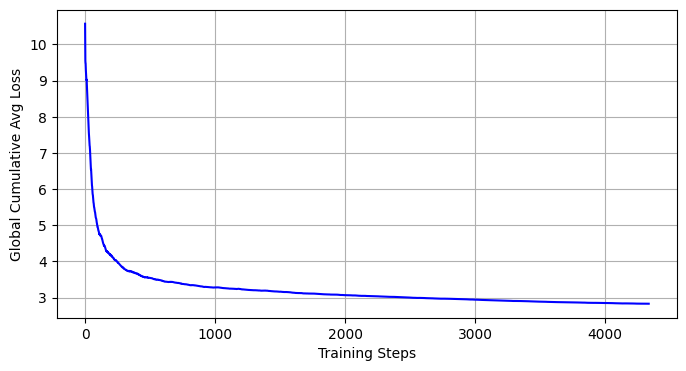

In [ ]:
# Sanity check: decreasing trend of global average training loss
plt.figure(figsize=(8,4))
plt.plot(global_train_losses, label="Global Avg Train Loss", color='blue')
plt.xlabel("Training Steps")
plt.ylabel("Global Cumulative Avg Loss")
plt.grid(True)
plt.show()

# Task 2: English NLI with GPT-2
In this task, you will:
- Load a pretrained GPT-2 model with official weights and perform a dummy text generation.
- Load an English Natural Language Inference (NLI) dataset.
- Fine-tune the loaded model and evaluate its performance.

## Model Loading & Text Generation

In [ ]:
@torch.no_grad()
def generate_gpt2(model, tokenizer, input_ids, max_gen_length=50, device="cuda"):
    """
    Generate text from a GPT-2 model given a single input sequence (greedy decoding).

    Note:
        - Currently only supports batch_size=1 (single input sequence).
        - Using greedy decoding, so each run with the same input produces the same output.
        - Other sampling-based decoding methods (e.g., top-k, top-p, temperature) can introduce randomness and yield different outputs each run.

    Args:
        model: GPT-2 model (pretrained or fine-tuned)
        tokenizer: GPT-2 tokenizer
        input_ids: torch.LongTensor of shape [1, seq_len], input token IDs
        max_gen_length: int, maximum number of tokens to generate
        device: str, "cuda" or "cpu"

    Returns:
        str: Generated text
    """
    model.eval()
    input_ids = input_ids.to(device)  # move input to device
    output_ids = input_ids.clone()

    """
    TODO-8: Greedy next-token generation loop

    Implementation hints:
    Repeat the below steps up to max_gen_length:
    1. Construct an attention mask based on current output_ids (non-pad tokens).
    2. Pass output_ids and attention_mask through the model to get hidden states.
    3. Convert the last hidden state to logits over the vocabulary using model.hidden_state_to_token.
    4. Select the next token using greedy decoding (argmax over logits).
    5. Append the next token to output_ids.
    6. Stop the loop early if the EOS token is generated.

    """
    ### YOUR CODE HERE

    # Store initial length to track how many NEW tokens to generate
    initial_length = len(output_ids[0])
    while len(output_ids[0]) < initial_length + max_gen_length:

        # Construct an attention mask based on current output_ids (non-pad tokens).
        attention_mask = torch.ones_like(output_ids)

        # Pass output_ids and attention_mask through the model to get hidden states.
        hidden_states = model(output_ids, attention_mask)['last_hidden_state']

        # Convert the last hidden state to logits over the vocabulary using model.hidden_state_to_token.
        logits = model.hidden_state_to_token(hidden_states)

        # Select the next token using greedy decoding (argmax over logits).
        last_token = logits[:, -1, :]   # [batch_size, vocab_size]
        next_token = torch.argmax(last_token, dim=1)

        # Append the next token to output_ids.
        next_token = next_token.unsqueeze(1)    # add sequence dimension
        output_ids = torch.cat([output_ids, next_token], dim=1)

        # Stop the loop early if the EOS token is generated.
        if next_token.item() == tokenizer.eos_token_id:
            break

    # raise NotImplementedError

    # Decode generated tokens to string
    ids = output_ids[0]
    text = tokenizer.decode(ids, skip_special_tokens=True)

    return text

In [ ]:
# Load a pretrained GPT-2 model with official weights
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained("gpt2").to(DEVICE)

In [ ]:
# Dummy text generation using the pretrained GPT-2 model with official weights
dummy_texts = "Singapore University of Technology and Design (SUTD) is"
input_ids = tokenizer(dummy_texts, return_tensors="pt", padding=True)['input_ids']
generated_texts = generate_gpt2(model, tokenizer, input_ids, max_gen_length=50, device=DEVICE)
print(generated_texts)

Singapore University of Technology and Design (SUTD) is a leading research institute in the field of design and engineering. It is the first university in Singapore to offer a full-time, full-time, full-time, full-time, full-time, full-time, full-time,


In [ ]:
# Dummy text generation using the toy GPT-2 model trained in Task 1
generated_texts = generate_gpt2(toy_gpt2_model, tokenizer, input_ids, max_gen_length=50, device=DEVICE)
print(generated_texts)

Singapore University of Technology and Design (SUTD) is a $3.


## Load NLI Dataset

In [ ]:
def compute_accuracy(preds, labels):
    correct = sum(p.lower().strip() == l.lower().strip() for p, l in zip(preds, labels))
    return correct / len(labels)

def evaluate_gpt2_xnli(model, tokenizer, dataloader, max_gen_length=10, device="cuda"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for item in tqdm(dataloader, desc="Generating"):
            input_ids = item['input_ids']
            gen_text = generate_gpt2(model, tokenizer, input_ids, max_gen_length=max_gen_length, device=device)
            pred_label = gen_text.split("Label:")[-1].strip()
            all_preds.append(pred_label)
            all_labels.extend(item['label_strs'])
    acc = compute_accuracy(all_preds, all_labels)
    print(f"Evaluation accuracy: {acc*100:.2f}%")
    return acc, all_preds, all_labels

class XNLIDataset(Dataset):
    """
    A PyTorch Dataset for XNLI (Cross-lingual Natural Language Inference) task.

    Supports train, dev, and test splits in a specific language,
    tokenizes text inputs for GPT-style models, and optionally subsamples the dataset.

    Attributes:
        split (str): Dataset split, one of 'train', 'dev', 'test'.
        lang (str): Language code (e.g., 'en', 'zh').
        tokenizer: A HuggingFace tokenizer to convert text to input IDs.
        max_length (int): Maximum sequence length for tokenization.
        LABEL2ID (dict): Mapping from textual labels to integer IDs.
        ID2LABEL (dict): Reverse mapping from integer IDs to textual labels.
        data (pd.DataFrame): The loaded and preprocessed dataset.
    """
    def __init__(
        self,
        split="train",
        lang="en",
        train_path_template="XNLI-MT-1.0/multinli/multinli.train.{lang}.tsv",
        test_path="XNLI-1.0/xnli.test.tsv",
        dev_path="XNLI-1.0/xnli.dev.tsv",
        tokenizer=None,
        max_length=1024,
        subset = 1.0  # 0~1
    ):
        self.split = split
        self.lang = lang
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.LABEL2ID = {"entailment": 0, "contradictory": 1, "neutral": 2}
        self.ID2LABEL = {v: k for k, v in self.LABEL2ID.items()}

        if split == "train":
            path = train_path_template.format(lang=lang)
            df = self.read_xnli_tsv(path, split)
            df = df.dropna(subset=['premise','hypo','label'])
        elif split in ["dev", "test"]:
            path = test_path if split=="test" else dev_path
            df = self.read_xnli_tsv(path, split)
            df = df[df['language']==lang].copy()
            keep_cols = ['sentence1', 'sentence2', 'gold_label']
            df = df[keep_cols].dropna()
            df.rename(columns={'sentence1':'premise','sentence2':'hypo','gold_label':'label'}, inplace=True)
            df['label'] = df['label'].replace({'contradiction': 'contradictory'})
        else:
            raise ValueError("split must be one of ['train','dev','test']")

        original_num = len(df)
        if subset < 1.0:
            n = max(1, int(len(df) * subset))
            df = df.iloc[:n].reset_index(drop=True)
        subset_num = len(df)

        self.data = df.reset_index(drop=True)
        print(f"Dataset initialized: split='{split}', lang='{lang}', total={original_num}, subset={subset}, subset_count={subset_num}")

    def read_xnli_tsv(self, path, split):
        """
        Read an XNLI TSV file and return it as a pandas DataFrame.

        Args:
            path (str): Path to the TSV file.
            split (str): One of "train", "dev", "test" indicating the dataset split.

        Returns:
            pd.DataFrame: The dataset as a DataFrame with appropriate columns.
        """
        if split == "train":
            with open(path, "r", encoding="utf-8") as f:
                lines = f.read().splitlines()
            header = lines[0].split("\t")
            data = []
            for i, line in enumerate(lines[1:], start=2):
                parts = line.split("\t")
                if len(parts) == len(header):
                    data.append(parts)
                else:
                    print(f"skip row {i}: {len(parts)} cols → {parts[:2]}")
        else:
            with open(path, "r", encoding="utf-8") as f:
                reader = csv.reader(f, delimiter="\t")
                rows = list(reader)
            header = rows[0]
            expected_cols = len(header)
            data = []
            for i, row in enumerate(rows[1:], start=2):
                if len(row) == expected_cols:
                    data.append(row)
                else:
                    print(f"skip row {i}: {len(row)} cols → {row[:2]}")
        return pd.DataFrame(data, columns=header)

    def __len__(self):
        """Return the number of examples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieve a single example by index and tokenize it.

        For training split:
            - Constructs the input as "Premise: ... Hypothesis: ... Label: ..."
            - Tokenizes the full input.
            - Masks the prefix tokens in the labels with -100 for GPT loss computation.

        For dev/test split:
            - Constructs the input without label as "Premise: ... Hypothesis: ... Label:"

        Returns:
            dict: Contains 'input_ids', 'attention_mask', 'labels' (train only), 'label_str'
        """
        row = self.data.iloc[idx]
        premise = row['premise']
        hypo = row['hypo']
        label = row['label']
        if self.lang == 'zh': # de-tokenize for Chinese
            premise = premise.replace(" ", "")
            hypo = hypo.replace(" ", "")

        if self.split == "train":
            prefix = f"Premise: {premise}\nHypothesis: {hypo}\nLabel:"
            full_text = prefix + str(self.LABEL2ID[label])
            tokenized = self.tokenizer(
                full_text,
                truncation=True,
                max_length=self.max_length,
                padding=False,
                return_tensors="pt"
            )
            tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}

            prefix_ids = self.tokenizer(prefix).input_ids
            labels_ids = tokenized['input_ids'].clone()
            labels_ids[:len(prefix_ids)] = -100 # Masks the prefix tokens in the labels with -100 for GPT loss computation.
            tokenized['labels'] = labels_ids
            tokenized['label_str'] = str(self.LABEL2ID[label])
            return tokenized
        else:
            text = f"Premise: {premise}\nHypothesis: {hypo}\nLabel:"
            tokenized = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding=False,
                return_tensors="pt"
            )
            tokenized = {k: v.squeeze(0) for k, v in tokenized.items()}
            tokenized['label_str'] = str(self.LABEL2ID[label])
            return tokenized

    @staticmethod
    def collate_fn(batch):
        """
        Collate a batch of examples into padded tensors.

        Pads 'input_ids' and 'attention_mask' to the max length in the batch.
        Pads 'labels' with -100 if present.
        Collects 'label_str' for reference.

        Returns:
            dict: Padded tensors and label strings for the batch.
        """
        input_ids = torch.nn.utils.rnn.pad_sequence(
            [b['input_ids'] for b in batch],
            batch_first=True,
            padding_value=0
        )
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [b['attention_mask'] for b in batch],
            batch_first=True,
            padding_value=0
        )

        if 'labels' in batch[0]:
            labels = torch.nn.utils.rnn.pad_sequence(
                [b['labels'] for b in batch],
                batch_first=True,
                padding_value=-100
            )
        else:
            labels = None

        label_strs = [b['label_str'] for b in batch]

        out = {"input_ids": input_ids, "attention_mask": attention_mask, "label_strs": label_strs}
        if labels is not None:
            out["labels"] = labels
        return out

In [ ]:
"""
Load NLI datasets for fine-tuning and evaluation.
For debugging on a CPU, you can set SUBSET to a float in (0,1) to load only a fraction of the data.
Final training and evaluation should use the full dataset (SUBSET=1).
"""

TRAIN_SUBSET = 1
DEV_SUBSET = 1
TEST_SUBSET = 1

train_dataset = XNLIDataset(
    split="train",
    lang="en",
    tokenizer=tokenizer,
    subset=TRAIN_SUBSET
)

dev_dataset = XNLIDataset(
    split="dev",
    lang="en",
    tokenizer=tokenizer,
    subset=DEV_SUBSET
)

test_dataset = XNLIDataset(
    split="test",
    lang="en",
    tokenizer=tokenizer,
    subset=TEST_SUBSET
)

Dataset initialized: split='train', lang='en', total=392702, subset=1, subset_count=392702
Dataset initialized: split='dev', lang='en', total=2490, subset=1, subset_count=2490
Dataset initialized: split='test', lang='en', total=5010, subset=1, subset_count=5010


## Fine-tune GPT-2

In [ ]:
# Hyperparamter of gpt2 fine-tuning
EPOCHS = 1
BATCH_SIZE = 4
LR = 5e-5
WEIGHT_DECAY = 0.01
CORRECT_BIAS = True

In [ ]:
# Create DataLoaders for training and validation datasets
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,collate_fn=XNLIDataset.collate_fn)
dev_loader = DataLoader(dev_dataset,shuffle=False,collate_fn=XNLIDataset.collate_fn)

VOCAB_SIZE = tokenizer.vocab_size

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, correct_bias=CORRECT_BIAS)
# Track training progress
global_train_losses = []
total_train_loss = 0.0
total_train_steps = 0
print_interval = 10

# Track best dev accuracy for model saving
# This only works for epoch > 1
best_dev_acc = 0.0
SAVE_DIR = "best_model"
os.makedirs(SAVE_DIR, exist_ok=True)

# Training loop
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    model.train()
    # Iterate over batches
    loop = tqdm(train_loader, desc="Training")
    for batch in loop:
        input_ids = batch["input_ids"].to(DEVICE)        # [B, seq_len]
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch.get("labels").to(DEVICE)                    # [B, seq_len]

        optimizer.zero_grad()

        hidden_states = model(input_ids=input_ids, attention_mask=attention_mask)['last_hidden_state']  # [B, seq_len, hidden]

        """
        TODO-9: Compute next-token loss from hidden states and update model parameters.

        Implementation hints:
        1. Convert hidden states to logits over the vocabulary using model.hidden_state_to_token.
        2. Shift logits and labels for next-token prediction to align each prediction with the correct next token.
        3. Compute the cross-entropy loss, making sure positions with label=-100 are ignored.
        4. Backpropagate and update model parameters.
        """

        ### YOUR CODE HERE

        # Convert hidden states to logits over the vocabulary using model.hidden_state_to_token.
        logits = model.hidden_state_to_token(hidden_states)

        # Shift logits and labels for next-token prediction to align each prediction with the correct next token.
        logits = logits[:, :-1, :]
        labels = labels[:, 1:]

        # Compute the cross-entropy loss, making sure positions with label=-100 are ignored.
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1), ignore_index=-100)

        # Backpropagate and update the model parameters.
        loss.backward()
        optimizer.step()

        # raise NotImplementedError

        total_train_loss += loss.item()
        total_train_steps += 1
        global_train_avg_loss = total_train_loss / total_train_steps
        global_train_losses.append(global_train_avg_loss)

        loop.set_postfix({'avg_loss': f"{global_train_avg_loss:.4f}"})

    print(f"Epoch {epoch+1} finished | Global Avg Loss: {global_train_avg_loss:.4f}")

    acc, all_preds, all_labels = evaluate_gpt2_xnli(model, tokenizer, dev_loader, max_gen_length=1, device=DEVICE)


    if acc > best_dev_acc:
        best_dev_acc = acc
        torch.save(model.state_dict(), f"{SAVE_DIR}/model.pt")
        print(f"New best model saved at {SAVE_DIR}/model.pt with dev accuracy {best_dev_acc*100:.2f}%")

Epoch 1/1


Training: 100%|██████████| 98176/98176 [1:57:03<00:00, 13.98it/s, avg_loss=0.6160]


Epoch 1 finished | Global Avg Loss: 0.6160


Generating: 100%|██████████| 2490/2490 [00:34<00:00, 72.05it/s]


Evaluation accuracy: 79.52%
New best model saved at best_model/model.pt with dev accuracy 79.52%


In [ ]:
# Diagnostic: Check what the model is actually generating
# Run this after training to debug 0% accuracy issues

print("="*60)
print("DIAGNOSTIC: Checking model predictions")
print("="*60)

# Get a few examples from dev set
model.eval()
sample_batch = next(iter(dev_loader))
input_ids_sample = sample_batch['input_ids'][:3].to(DEVICE)
labels_sample = sample_batch['label_strs'][:3]

print(f"\nExpected labels: {labels_sample}")
print("\nGenerated outputs:")

with torch.no_grad():
    for i, (input_id, true_label) in enumerate(zip(input_ids_sample, labels_sample)):
        input_id = input_id.unsqueeze(0)  # Add batch dimension
        gen_text = generate_gpt2(model, tokenizer, input_id, max_gen_length=5, device=DEVICE)

        # Try different parsing methods
        pred_raw = gen_text.split("Label:")[-1].strip()

        # Extract first digit if present
        import re
        digits = re.findall(r'\d+', pred_raw)
        pred_digit = digits[0] if digits else "NO_DIGIT"

        print(f"\nExample {i+1}:")
        print(f"  Full generated text: {repr(gen_text)}")
        print(f"  After 'Label:': {repr(pred_raw)}")
        print(f"  Extracted digit: {pred_digit}")
        print(f"  True label: {true_label}")
        print(f"  Match: {pred_digit == true_label}")

print("\n" + "="*60)
print("If you see 'NO_DIGIT' or mismatches, the model isn't generating")
print("the expected format. Try increasing max_gen_length or check training.")
print("="*60)


DIAGNOSTIC: Checking model predictions

Expected labels: ['2']

Generated outputs:

Example 1:
  Full generated text: "Premise: And he said, Mama, I'm home.\nHypothesis: He called his mom as soon as the school bus dropped him off.\nLabel:22222"
  After 'Label:': '22222'
  Extracted digit: 22222
  True label: 2
  Match: False

If you see 'NO_DIGIT' or mismatches, the model isn't generating
the expected format. Try increasing max_gen_length or check training.


In [ ]:
# Sanity check: after fine-tuning, the accuracy should be better than random guessing (33.33%)
# The accuracy we got is around 77.96% using whole training data and 1 epoch
SAVE_DIR = "best_model"
finetuned_model = GPT2Model(GPT2Config()).to(DEVICE)
finetuned_model.load_state_dict(torch.load(f"{SAVE_DIR}/model.pt"))
test_loader = DataLoader(test_dataset,shuffle=False,collate_fn=XNLIDataset.collate_fn)
acc, all_preds, all_labels = evaluate_gpt2_xnli(finetuned_model, tokenizer, test_loader, max_gen_length=1, device=DEVICE)

Generating: 100%|██████████| 5010/5010 [01:09<00:00, 72.47it/s]

Evaluation accuracy: 78.82%


# Task 3: Multilingual NLI with GPT-2

In this task, you will:

- Test the fine-tuned GPT-2 on non-English languages for zero-shot cross-lingual transfer.

- For each non-English language, fine-tune a model on the corresponding training set.

- Fine-tune a unified model on the training sets of all languages.

## Zero-shot Cross-lingual Transfer

In [ ]:
langs = ['en', 'ar', 'bg', 'de','el','es','fr','hi','ru','sw','th','tr','ur','vi','zh']

In [ ]:
TEST_SUBSET = 1
path = f"{SAVE_DIR}/model.pt"
finetuned_model = GPT2Model(GPT2Config()).to(DEVICE)
finetuned_model.load_state_dict(torch.load(path))
all_test_datasets = {}
all_test_loader = {}
for lang in langs:
    test_dataset = XNLIDataset(split="test", lang=lang, tokenizer=tokenizer, max_length=1024, subset=TEST_SUBSET)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=XNLIDataset.collate_fn)
    all_test_datasets[lang] = test_dataset
    all_test_loader[lang] = test_loader

all_results = {}
for lang in langs:
    test_loader = all_test_loader[lang]
    if lang == "en":
        print(f"Evaluating on {lang}...")
    else:
        print(f"Evaluating zero-shot on {lang}...")
    acc, all_preds, all_labels = evaluate_gpt2_xnli(finetuned_model, tokenizer, test_loader, max_gen_length=1, device=DEVICE)
    all_results[lang] = acc

print("Zero-shot cross-lingual accuracy per language:")
for lang, acc in all_results.items():
    print(f"{lang}: {acc*100:.2f}%")

Dataset initialized: split='test', lang='en', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='ar', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='bg', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='de', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='el', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='es', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='fr', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='hi', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='ru', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='sw', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='th', total=5010, subset=1, subset_count=5010
Dataset initialized: split='test', lang='tr', total=50

Generating: 100%|██████████| 5010/5010 [01:09<00:00, 72.39it/s]


Evaluation accuracy: 78.82%
Evaluating zero-shot on ar...


Generating: 100%|██████████| 5010/5010 [01:18<00:00, 63.72it/s]


Evaluation accuracy: 35.89%
Evaluating zero-shot on bg...


Generating: 100%|██████████| 5010/5010 [01:22<00:00, 60.74it/s]


Evaluation accuracy: 37.23%
Evaluating zero-shot on de...


Generating: 100%|██████████| 5010/5010 [01:12<00:00, 69.05it/s]


Evaluation accuracy: 40.76%
Evaluating zero-shot on el...


Generating: 100%|██████████| 5010/5010 [01:24<00:00, 59.22it/s]


Evaluation accuracy: 35.09%
Evaluating zero-shot on es...


Generating: 100%|██████████| 5010/5010 [01:11<00:00, 69.89it/s]


Evaluation accuracy: 46.17%
Evaluating zero-shot on fr...


Generating: 100%|██████████| 5010/5010 [01:12<00:00, 69.41it/s]


Evaluation accuracy: 42.18%
Evaluating zero-shot on hi...


Generating: 100%|██████████| 5010/5010 [01:27<00:00, 57.11it/s]


Evaluation accuracy: 34.77%
Evaluating zero-shot on ru...


Generating: 100%|██████████| 5010/5010 [01:22<00:00, 60.45it/s]


Evaluation accuracy: 37.64%
Evaluating zero-shot on sw...


Generating: 100%|██████████| 5010/5010 [01:12<00:00, 69.47it/s]


Evaluation accuracy: 36.51%
Evaluating zero-shot on th...


Generating: 100%|██████████| 5010/5010 [01:32<00:00, 54.16it/s]


Evaluation accuracy: 34.71%
Evaluating zero-shot on tr...


Generating: 100%|██████████| 5010/5010 [01:13<00:00, 67.85it/s]


Evaluation accuracy: 38.00%
Evaluating zero-shot on ur...


Generating: 100%|██████████| 5010/5010 [01:23<00:00, 60.03it/s]


Evaluation accuracy: 34.89%
Evaluating zero-shot on vi...


Generating: 100%|██████████| 5010/5010 [01:18<00:00, 63.44it/s]


Evaluation accuracy: 36.97%
Evaluating zero-shot on zh...


Generating: 100%|██████████| 5010/5010 [01:15<00:00, 65.99it/s]

Evaluation accuracy: 37.62%
Zero-shot cross-lingual accuracy per language:
en: 78.82%
ar: 35.89%
bg: 37.23%
de: 40.76%
el: 35.09%
es: 46.17%
fr: 42.18%
hi: 34.77%
ru: 37.64%
sw: 36.51%
th: 34.71%
tr: 38.00%
ur: 34.89%
vi: 36.97%
zh: 37.62%


## Fertility-based Language Selection

Guidance: You may notice that some languages achieve reasonable zero-shot cross-lingual performance. This is likely because these languages are closer to English (e.g., in writing system), making cross-lingual transfer from English easier. However, many other languages perform close to random guessing, which is expected since GPT-2 was pretrained entirely on English data.

To perform further multilingual fine-tuning, we need to identify which languages GPT-2 can realistically support (because if a language is not supported, fine-tuning on it will have little effect). A straightforward way to check this is to inspect the tokens in the model’s tokenizer. However, this is not practical for GPT-2-like models, because they use a Byte-Pair Encoding (BPE) tokenizer. BPE can decompose any Unicode string into subwords, even if the string never appeared in training, making it difficult to determine whether a language is truly supported.

Instead, we can approximate tokenizer support using fertility, a metric that measures the average number of subwords produced per word. Lower fertility indicates better tokenizer quality and compression, while high fertility suggests heavy fragmentation, which can hurt model performance. By combining fertility analysis with zero-shot cross-lingual results, we can identify a subset of languages that GPT-2 can reasonably handle (a rough estimate, as officially GPT-2 is designed for English). Then, we can proceed with multilingual fine-tuning experiments on these languages.

Reference: How Good is Your Tokenizer? On the Monolingual Performance of Multilingual Language Models

In [ ]:
def compute_fertility(dataset, tokenizer):
    """
    Compute average fertility for a dataset.
    Fertility = #tokens / #words
    Note: word splitting is approximate and uses whitespace.
    """
    total_words = 0
    total_tokens = 0
    samples = len(dataset)

    for i in tqdm(range(samples), desc="Computing fertility"):
        row = dataset.data.iloc[i]
        for sent in [row['premise'], row['hypo']]:
            words = sent.strip().split()  # crude word estimate
            tokens = tokenizer.tokenize(sent)
            total_words += len(words)
            total_tokens += len(tokens)

    fertility = total_tokens / total_words if total_words > 0 else 0.0
    return fertility

In [ ]:
subset_for_check = 0.01

for lang in langs:
    train_dataset = XNLIDataset(
        split="train",
        lang=lang,
        tokenizer=tokenizer,
        subset=subset_for_check
    )
    fertility_score = compute_fertility(train_dataset, tokenizer)
    print(f"{lang}: fertility = {fertility_score:.2f}")

Dataset initialized: split='train', lang='en', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:00<00:00, 4439.79it/s]


en: fertility = 1.11
Dataset initialized: split='train', lang='ar', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2442.76it/s]


ar: fertility = 4.70
Dataset initialized: split='train', lang='bg', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2188.47it/s]


bg: fertility = 5.53
Dataset initialized: split='train', lang='de', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2811.57it/s]


de: fertility = 2.10
Dataset initialized: split='train', lang='el', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2130.26it/s]


el: fertility = 6.16
Dataset initialized: split='train', lang='es', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 3058.37it/s]


es: fertility = 1.83
Dataset initialized: split='train', lang='fr', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 3047.66it/s]


fr: fertility = 1.75
Dataset initialized: split='train', lang='hi', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2432.68it/s]


hi: fertility = 5.12
Dataset initialized: split='train', lang='ru', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2019.85it/s]


ru: fertility = 5.90
Dataset initialized: split='train', lang='sw', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:00<00:00, 3952.29it/s]


sw: fertility = 2.08
Dataset initialized: split='train', lang='th', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 2472.20it/s]


th: fertility = 9.48
Dataset initialized: split='train', lang='tr', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 3051.58it/s]


tr: fertility = 2.73
Dataset initialized: split='train', lang='ur', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 3607.82it/s]


ur: fertility = 5.16
Dataset initialized: split='train', lang='vi', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 3588.65it/s]


vi: fertility = 3.62
Dataset initialized: split='train', lang='zh', total=392702, subset=0.01, subset_count=3927


Computing fertility: 100%|██████████| 3927/3927 [00:01<00:00, 3758.96it/s]

zh: fertility = 3.77


## Fine-tune GPT-2 (per-language)

Guidance: Load the pretrained GPT-2 (not the ones fine-tuned on English NLI) along with the training data for a single target language. Choose non-English languages that performed well in the zero-shot cross-lingual transfer and fertility evaluation. It depends on you how many languages to include. Fine-tune a separate model for each selected language. Afterwards, compare these per-language fine-tuned models with the zero-shot cross-lingual transfer results.

## Fine-tune GPT-2 (all)

Guidance: Load the pretrained GPT-2 (again, not the ones fine-tuned on English NLI) along with the training data for all target languages, including English. For non-English languages, select those that performed well in the zero-shot cross-lingual transfer and fertility evaluation. It depends on you how many languages to include. Fine-tune a single model on this combined multilingual dataset. Afterwards, compare this model with the per-language fine-tuned models and the zero-shot cross-lingual transfer results.

# QWEN MODEL

In [ ]:
# import Qwen
qwen_model_name = "Qwen/Qwen2-0.5B"
qwen_tokenizer = AutoTokenizer.from_pretrained(qwen_model_name, trust_remote_code=True)
qwen_tokenizer.pad_token = qwen_tokenizer.eos_token

qwen_model = AutoModelForCausalLM.from_pretrained(
  qwen_model_name,
  torch_dtype=torch.bfloat32,
  device_map="auto",
  trust_remote_code=True
)

In [ ]:
# using LoRA for optimised parameter training
from peft import LoraConfig, get_peft_model, TaskType
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    bias="none",
)

# Apply LoRA
qwen_model = get_peft_model(qwen_model, lora_config)

In [ ]:
EPOCHS = 1
BATCH_SIZE = 32
LR = 2e-4
WEIGHT_DECAY = 0.01
CORRECT_BIAS = True

In [ ]:
def qwen_finetuned(qwen_model, qwen_tokenizer):
  # training dataset
  train_dataset = XNLIDataset(
          split="train",
          lang="en",
          tokenizer=qwen_tokenizer,
          subset=TRAIN_SUBSET
      )

  train_loader = DataLoader(
      train_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      collate_fn=XNLIDataset.collate_fn
  )

  qwen_model.to(DEVICE)
  optimizer = AdamW(qwen_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

  # Enable automatic mixed precision
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

  global_train_losses = []
  total_train_loss = 0.0
  total_train_steps = 0
  print_interval = 100

  for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")
    qwen_model.train()

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):

        input_ids = batch["input_ids"].to(DEVICE, non_blocking=True)
        attention_mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
        labels = batch.get("labels").to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        # Mixed precision training
        with torch.cuda.amp.autocast(dtype=torch.bfloat16):  # A100 optimized
            outputs = qwen_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss

        # Scale loss and backward
        if scaler:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        loss_value = loss.item()
        total_train_loss += loss_value
        total_train_steps += 1
        global_train_avg_loss = total_train_loss / total_train_steps
        global_train_losses.append(global_train_avg_loss)

        if batch_idx % print_interval == 0:
          print(f"Train | Epoch {epoch} | Batch {batch_idx} | Global Avg Train Loss: {global_train_avg_loss:.4f} | Current Loss: {loss_value:.4f}")


  print("Training Complete.")
  return qwen_model

In [ ]:
# actual training
qwen_finetuned = qwen_finetuned(qwen_model, qwen_tokenizer)
qwen_finetuned.save_pretrained("./qwen_finetuned_2hr")
qwen_tokenizer.save_pretrained("./qwen_finetuned_2hr")

In [ ]:
def evaluate_model_nli(model, tokenizer, dataloader, model_type="gpt2", device="cuda"):
    """
    Unified evaluation for BOTH GPT-2 and Qwen
    - model_type: "gpt2" or "qwen"
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_type}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device) if 'attention_mask' in batch else None
            true_labels = batch['label_strs']

            if model_type == "gpt2":
                gen_text = generate_gpt2(model, tokenizer, input_ids, max_gen_length=3, device=device)
                pred_label = gen_text.split("Label:")[-1].strip()
                all_preds.append(pred_label)
            else:
                generated_ids = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_new_tokens=3,
                    do_sample=False,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )

                # Decode predictions
                for i in range(len(generated_ids)):
                    # Get only newly generated tokens
                    input_len = input_ids[i].shape[0]
                    generated_tokens = generated_ids[i][input_len:]
                    gen_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)

                    # Extract label
                    pred_label = gen_text.strip()
                    all_preds.append(pred_label)

            all_labels.extend(true_labels)

    # Calculate accuracy
    correct = sum(p == l for p, l in zip(all_preds, all_labels))
    accuracy = correct / len(all_labels)

    print(f"{model_type.upper()} Evaluation accuracy: {accuracy*100:.2f}%")
    return accuracy, all_preds, all_labels

In [ ]:
TEST_SUBSET = 1
BATCH_SIZE = 1

test_languages = ['en', 'es', 'fr', 'de', 'zh']
results = {'gpt2': {}, 'qwen': {}}

for lang in test_languages:
    print(f"\n{'='*60}")
    print(f"Testing on {lang}")
    print(f"{'='*60}")

    # Create GPT-2 test dataset
    gpt2_test_dataset = XNLIDataset(
        split="test",
        lang=lang,
        tokenizer=tokenizer,
        subset=TEST_SUBSET
    )
    gpt2_test_loader = DataLoader(gpt2_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                  collate_fn=XNLIDataset.collate_fn)

    # Create Qwen test dataset
    qwen_test_dataset = XNLIDataset(
        split="test",
        lang=lang,
        tokenizer=qwen_tokenizer,
        subset=TEST_SUBSET
    )
    qwen_test_loader = DataLoader(qwen_test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                  collate_fn=XNLIDataset.collate_fn)

    # Evaluate GPT-2
    print("\n[GPT-2 Evaluation]")
    gpt2_acc, _, _ = evaluate_model_nli(
        finetuned_model, tokenizer, gpt2_test_loader,
        model_type="gpt2", device=DEVICE
    )
    results['gpt2'][lang] = gpt2_acc

    # Evaluate Qwen
    print("\n[Qwen Evaluation]")
    qwen_acc, _, _ = evaluate_model_nli(
        qwen_finetuned, qwen_tokenizer, qwen_test_loader,
        model_type="qwen", device=DEVICE
    )
    results['qwen'][lang] = qwen_acc

    print(f"\n{lang}: GPT-2 = {gpt2_acc*100:.1f}% | Qwen = {qwen_acc*100:.1f}%")